In [1]:
from superdebug import debug
from process_data import get_model_input
from train import evaluate_model, get_normalization_weights
from model import get_best_model, TransformerVoter
from utils import get_config, load_model, save_model, to_device, parse_config
import pandas as pd
import numpy as np
import torch
from collections import Counter
import random
config = get_config("configs/finetune_CURIO_tmp.yml", "_test", print_config=False)
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, train_submission_upvote_df, num_all_users = get_model_input(config)
model = TransformerVoter(config, categorical_features, string_features, original_feature_map)
extra_input = (categorical_features, string_features, target)

为了使用邮件提醒功能，请设置环境变量MY_QQ_EMAIL（QQ邮箱地址）与MY_QQ_EMAIL_PWD（QQ邮箱授权码）
------------------ 2022-10-24 13:45:07 ------------------


Version 7.5.0 of praw is outdated. Version 7.6.0 was released Tuesday May 10, 2022.
DeepCTR-PyTorch version 0.2.9 detected. Your version is 0.2.8.
Use `pip install -U deepctr-torch` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR-Torch/releases/tag/v0.2.9


GPU ready...
Smart using cuda:2
------------------ 2022-10-24 13:45:11 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:364 get_model_input
Loading prepared data...
------------------ 2022-10-24 13:45:11 ------------------
------------------ 2022-10-24 13:45:13 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:251 get_tokenizer
0 / 1.  original_token_num num val: 30522
------------------ 2022-10-24 13:45:13 ------------------
------------------ 2022-10-24 13:45:13 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:263 get_tokenizer
0 / 2.  latest_token_num num val: 30576
------------------ 2022-10-24 13:45:13 ------------------


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
len(set(train_data["SUBMISSION_ID"]) | set(test_data["SUBMISSION_ID"]))

384

In [3]:
# test_data = test_data.iloc[:10]
# test_data_info = test_data_info.iloc[:10]
all_subreddits = set(train_data["SUBREDDIT"])

Balance the test data so that for each Subreddit, upvote:downvote = 1:1

In [4]:
import random
test_data["select"] = [True] * len(test_data)
test_data_info["select"] = [True] * len(test_data_info)
test_data_list = []
test_data_info_list = []
for subreddit in all_subreddits:
    subreddit_data = test_data[test_data["SUBREDDIT"] == subreddit]
    subreddit_data_info = test_data_info[test_data["SUBREDDIT"] == subreddit]
    
    subreddit_data_upvotes = subreddit_data[subreddit_data["VOTE"] == 1].copy(deep=True)
    subreddit_data_downvotes = subreddit_data[subreddit_data["VOTE"] == 0].copy(deep=True)
    
    subreddit_data_info_upvotes = subreddit_data_info[subreddit_data["VOTE"] == 1].copy(deep=True)
    subreddit_data_info_downvotes = subreddit_data_info[subreddit_data["VOTE"] == 0].copy(deep=True)
    
    if len(subreddit_data_upvotes) > len(subreddit_data_downvotes):
        select_bool_vec = [True] * len(subreddit_data_downvotes) + [False] * (len(subreddit_data_upvotes) - len(subreddit_data_downvotes))
        random.shuffle(select_bool_vec)
        select_bool_vec = np.array(select_bool_vec)
        subreddit_data_upvotes = subreddit_data_upvotes
        subreddit_data_upvotes["select"] = select_bool_vec
        subreddit_data_upvotes = subreddit_data_upvotes[subreddit_data_upvotes["select"] == True]
        subreddit_data_info_upvotes = subreddit_data_info_upvotes
        subreddit_data_info_upvotes["select"] = select_bool_vec
        subreddit_data_info_upvotes = subreddit_data_info_upvotes[subreddit_data_info_upvotes["select"] == True]
    else:
        select_bool_vec = [True] * len(subreddit_data_upvotes) + [False] * (len(subreddit_data_downvotes) - len(subreddit_data_upvotes))
        random.shuffle(select_bool_vec)
        select_bool_vec = np.array(select_bool_vec)
        subreddit_data_downvotes = subreddit_data_downvotes
        subreddit_data_downvotes["select"] = select_bool_vec
        subreddit_data_downvotes = subreddit_data_downvotes[subreddit_data_downvotes["select"] == True]
        subreddit_data_info_downvotes = subreddit_data_info_downvotes
        subreddit_data_info_downvotes["select"] = select_bool_vec
        subreddit_data_info_downvotes = subreddit_data_info_downvotes[subreddit_data_info_downvotes["select"] == True]
    assert len(subreddit_data_upvotes) == len(subreddit_data_downvotes)
    assert len(subreddit_data_info_upvotes) == len(subreddit_data_info_downvotes)
    test_data_list.extend([subreddit_data_upvotes, subreddit_data_downvotes])
    test_data_info_list.extend([subreddit_data_info_upvotes, subreddit_data_info_downvotes])
test_data = pd.concat(test_data_list, axis = 0)
test_data_info = pd.concat(test_data_info_list, axis = 0)

In [5]:
a = list(Counter(test_data["SUBMISSION_ID"]).values())

Evaluation

/home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:46: RuntimeWarning: divide by zero encountered in true_divide
  minority_weight = 1/data["same_vote_rate"].to_numpy()


------------------ 2022-10-24 13:45:20 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:115 load_model
Loading latest model...
------------------ 2022-10-24 13:45:20 ------------------
75 parameters (fit: 75, expand: 0) initiated from 75


100%|██████████| 5/5 [00:00<00:00, 87.16it/s]


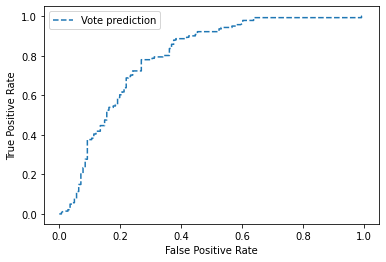

------------------ 2022-10-24 13:45:20 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:267 evaluate_model
How well can the model deal with cold start problem? Accuracy & confidence given different #votes on this post
------------------ 2022-10-24 13:45:20 ------------------


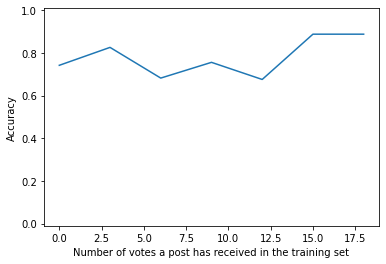

------------------ 2022-10-24 13:45:21 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:292 evaluate_model
How well can the model predict the lurkers' opinions? Accuracy & confidence given different #votes from this user
------------------ 2022-10-24 13:45:21 ------------------


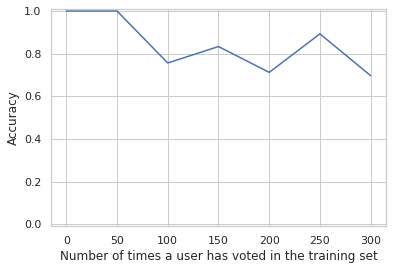

------------------ 2022-10-24 13:45:21 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:320 evaluate_model
How well can the model predict the minority opinions? Accuracy & confidence given different %votes that is same as the target vote
------------------ 2022-10-24 13:45:21 ------------------


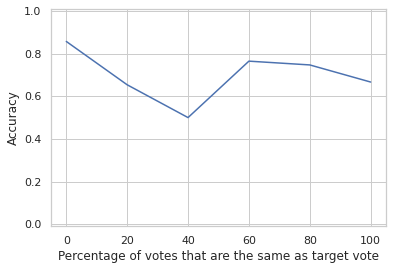

eval_all_test_data: - acc: 0.75177304964539 - acc_vote_0: 0.7304964539007093 - acc_vote_1: 0.7730496453900709 - auc: 0.7947789346612343 - auc_vote_0: None - auc_vote_1: None - acc_train_user_votes_num>=3: 0.75177304964539 - acc_vote_0_train_user_votes_num>=3: 0.7304964539007093 - acc_vote_1_train_user_votes_num>=3: 0.7730496453900709 - auc_train_user_votes_num>=3: 0.7947789346612343 - auc_vote_0_train_user_votes_num>=3: None - auc_vote_1_train_user_votes_num>=3: None - acc_train_submission_votes_num>=3: 0.7491039426523297 - acc_vote_0_train_submission_votes_num>=3: 0.7266187050359713 - acc_vote_1_train_submission_votes_num>=3: 0.7714285714285715 - auc_train_submission_votes_num>=3: 0.7926002055498458 - auc_vote_0_train_submission_votes_num>=3: None - auc_vote_1_train_submission_votes_num>=3: None - acc_train_submission_votes_num<=3: 0.7142857142857143 - acc_vote_0_train_submission_votes_num<=3: 0.6666666666666666 - acc_vote_1_train_submission_votes_num<=3: 1.0 - auc_train_submission_vo

/home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:46: RuntimeWarning: divide by zero encountered in true_divide
  minority_weight = 1/data["same_vote_rate"].to_numpy()
100%|██████████| 5/5 [00:00<00:00, 100.69it/s]


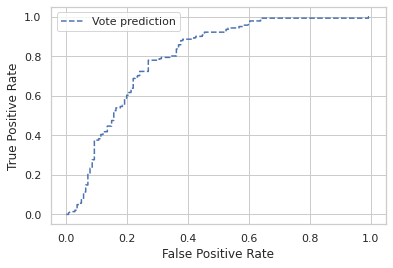

------------------ 2022-10-24 13:45:22 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:267 evaluate_model
How well can the model deal with cold start problem? Accuracy & confidence given different #votes on this post
------------------ 2022-10-24 13:45:22 ------------------


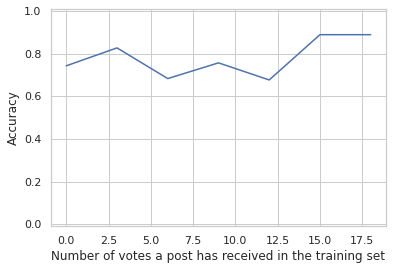

------------------ 2022-10-24 13:45:22 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:292 evaluate_model
How well can the model predict the lurkers' opinions? Accuracy & confidence given different #votes from this user
------------------ 2022-10-24 13:45:22 ------------------


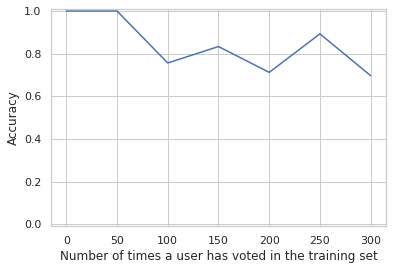

------------------ 2022-10-24 13:45:22 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:320 evaluate_model
How well can the model predict the minority opinions? Accuracy & confidence given different %votes that is same as the target vote
------------------ 2022-10-24 13:45:22 ------------------


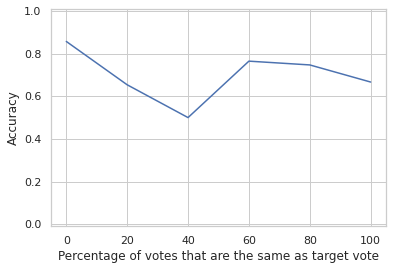

eval_all_test_data: - acc: 0.75177304964539 - acc_vote_0: 0.7304964539007093 - acc_vote_1: 0.7730496453900709 - auc: 0.7947789346612343 - auc_vote_0: None - auc_vote_1: None - acc_train_user_votes_num>=3: 0.75177304964539 - acc_vote_0_train_user_votes_num>=3: 0.7304964539007093 - acc_vote_1_train_user_votes_num>=3: 0.7730496453900709 - auc_train_user_votes_num>=3: 0.7947789346612343 - auc_vote_0_train_user_votes_num>=3: None - auc_vote_1_train_user_votes_num>=3: None - acc_train_submission_votes_num>=3: 0.7491039426523297 - acc_vote_0_train_submission_votes_num>=3: 0.7266187050359713 - acc_vote_1_train_submission_votes_num>=3: 0.7714285714285715 - auc_train_submission_votes_num>=3: 0.7926002055498458 - auc_vote_0_train_submission_votes_num>=3: None - auc_vote_1_train_submission_votes_num>=3: None - acc_train_submission_votes_num<=3: 0.7142857142857143 - acc_vote_0_train_submission_votes_num<=3: 0.6666666666666666 - acc_vote_1_train_submission_votes_num<=3: 1.0 - auc_train_submission_vo

In [6]:
model_types = ["latest", "best"]
for model_type in model_types:
    model, _, _, _, _ = load_model(config["save_model_dir"], model, model.optim, 0, 0, model_type)
    model.compile(torch.optim.Adam(model.parameters(), lr = model.config["learning_rate"]), model.config["loss_function"], metrics=["acc", "auc"])
    model.to(model.device)
    test_weights = get_normalization_weights(test_data, train_submission_upvote_df, config)
    if config["use_voted_users_feature"]:
        debug("Use all voted users as feature")
    eval_all_test_data = evaluate_model(config, model, data = test_data, weights = test_weights, batch_size=config['batch_size'], sample_voted_users=False, extra_input=extra_input, data_info = test_data_info, simple = False, smooth = True)
    eval_result_str = "".join([f"- {key}: {value:.4f} " if type(value) in [int, float] else f"- {key}: {value} " for key, value in eval_all_test_data.items()])
    print("eval_all_test_data:", eval_result_str)
    print([(k, eval_all_test_data["subreddit_acc"][k]) for k in config["selected_subreddits"] if k in eval_all_test_data["subreddit_acc"]])
    with open(config["log_path"], 'a') as log:
        log.write(f"Evaluation result of the {model_type} model (use all voted users as feature):" + eval_result_str+"\n")

    if config["use_voted_users_feature"] and config["sample_part_voted_users"]:
        debug("Sample part voted users as feature")
        eval_all_test_data = evaluate_model(config, model, data = test_data, weights = test_weights, batch_size=config['batch_size'], sample_voted_users=True, extra_input=extra_input, data_info = test_data_info, simple = False, smooth = True)
        eval_result_str = "".join([f"- {key}: {value:.4f} " for key, value in eval_all_test_data.items()])
        print("eval_all_test_data:", eval_result_str)
        with open(config["log_path"], 'a') as log:
            log.write(f"Evaluation result of the {model_type} model (sample part voted users as feature):" + eval_result_str+"\n")
    model.cpu()